# 3. Data Pre-processing

Data pre-processing techniques generally refer to the addition, deletion, or transformation of training set data. Different models have different sensitivities to the type of predictors in the model; *how* the predictors enter the model is also important.

The need for data pre-processing is determined by the type of model being used. Some procedures, such as tree-based models, are notably insensitive to the characteristics of the predictor data. Others, like linear regression, are not. In this chapter, a wide array of possible methodologies are discussed. 

How the predictors are encoded, called *feature engineering*, can have a significant impact on model performance. Often the most effective encoding of the data is informed by the modeler's understanding of the problem and thus is not derived from any mathematical techniques.

## 3.1 Case Study: Cell Segmentation in High-Content Screening

Check if data exists.

In [1]:
!ls -l ../datasets/segmentationOriginal/

total 4016
-rw-r--r--  1 leigong  staff  2053006 Nov 24 15:58 segmentationOriginal.csv


This dataset is from Hill et al. (2007) that consists of 2019 cells. Of these cells, 1300 were judged to be poorly segmented (PS) and 719 were well segmented (WS); 1009 cells were reserved for the training set.

In [2]:
import numpy as np
import pandas as pd

cell_segmentation = pd.read_csv("../datasets/segmentationOriginal/segmentationOriginal.csv")

In [3]:
cell_segmentation.shape

(2019, 120)

A first look at the dataset.

In [4]:
cell_segmentation.head(5)

Unnamed: 0       Cell   Case Class    AngleCh1  AngleStatusCh1  AreaCh1  \
0           1  207827637   Test    PS  143.247705               1      185   
1           2  207932307  Train    PS  133.752037               0      819   
2           3  207932463  Train    WS  106.646387               0      431   
3           4  207932470  Train    PS   69.150325               0      298   
4           5  207932455   Test    PS    2.887837               2      285   

   AreaStatusCh1  AvgIntenCh1  AvgIntenCh2     ...       VarIntenCh1  \
0              0    15.711864     3.954802     ...         12.474676   
1              1    31.923274   205.878517     ...         18.809225   
2              0    28.038835   115.315534     ...         17.295643   
3              0    19.456140   101.294737     ...         13.818968   
4              0    24.275735   111.415441     ...         15.407972   

   VarIntenCh3  VarIntenCh4  VarIntenStatusCh1  VarIntenStatusCh3  \
0     7.609035     2.714100                  0                  2   
1    56.715352   118.388139                  0                  0   
2    37.671053    49.470524                  0                  0   
3    30.005643    24.749537                  0                  0   
4    20.504288    45.450457                  0                  0   

   VarIntenStatusCh4   WidthCh1  WidthStatusCh1  XCentroid  YCentroid  
0                  2  10.642974               2         42         14  
1                  0  32.161261               1        215        347  
2                  0  21.185525               0        371        252  
3                  2  13.392830               0        487        295  
4                  0  13.198561               0        283        159  

[5 rows x 120 columns]

This chapter will use the training set samples to demonstrate data pre-processing techniques.

In [5]:
cell_segmentation.groupby('Case').count()

Unnamed: 0  Cell  Class  AngleCh1  AngleStatusCh1  AreaCh1  \
Case                                                                
Test         1010  1010   1010      1010            1010     1010   
Train        1009  1009   1009      1009            1009     1009   

       AreaStatusCh1  AvgIntenCh1  AvgIntenCh2  AvgIntenCh3     ...       \
Case                                                            ...        
Test            1010         1010         1010         1010     ...        
Train           1009         1009         1009         1009     ...        

       VarIntenCh1  VarIntenCh3  VarIntenCh4  VarIntenStatusCh1  \
Case                                                              
Test          1010         1010         1010               1010   
Train         1009         1009         1009               1009   

       VarIntenStatusCh3  VarIntenStatusCh4  WidthCh1  WidthStatusCh1  \
Case                                                                    
Test                1010               1010      1010            1010   
Train               1009               1009      1009            1009   

       XCentroid  YCentroid  
Case                         
Test        1010       1010  
Train       1009       1009  

[2 rows x 119 columns]

In [6]:
# separate training and test data
cell_train = cell_segmentation.ix[cell_segmentation['Case'] == 'Train']
cell_test = cell_segmentation.ix[cell_segmentation['Case'] == 'Test']

cell_train.head(5)

Unnamed: 0       Cell   Case Class    AngleCh1  AngleStatusCh1  AreaCh1  \
1            2  207932307  Train    PS  133.752037               0      819   
2            3  207932463  Train    WS  106.646387               0      431   
3            4  207932470  Train    PS   69.150325               0      298   
11          12  207932484  Train    WS  109.416426               0      256   
14          15  207932459  Train    PS  104.278654               0      258   

    AreaStatusCh1  AvgIntenCh1  AvgIntenCh2     ...       VarIntenCh1  \
1               1    31.923274   205.878517     ...         18.809225   
2               0    28.038835   115.315534     ...         17.295643   
3               0    19.456140   101.294737     ...         13.818968   
11              0    18.828571   125.938776     ...         13.922937   
14              0    17.570850   124.368421     ...         12.324971   

    VarIntenCh3  VarIntenCh4  VarIntenStatusCh1  VarIntenStatusCh3  \
1     56.715352   118.388139                  0                  0   
2     37.671053    49.470524                  0                  0   
3     30.005643    24.749537                  0                  0   
11    18.643027    40.331747                  0                  0   
14    17.747143    41.928533                  0                  0   

    VarIntenStatusCh4   WidthCh1  WidthStatusCh1  XCentroid  YCentroid  
1                   0  32.161261               1        215        347  
2                   0  21.185525               0        371        252  
3                   2  13.392830               0        487        295  
11                  2  17.546861               0        211        495  
14                  2  17.660339               0        172        207  

[5 rows x 120 columns]

## 3.2 Data Transformation for Individual Predictors

Transformations of predictor variables may be needed for several reasons. Some modeling techniques may have strict requirements, such as the predictors having a commom scale. In other cases, creating a good model may be difficult due to specific characteristics of the data (e.g., outliers).

### Centering and Scaling

To center a predictor variable, the average predictor value is substracted from all the values. As a result of centering, the predictor has a zero mean. Similarly, to scale the data, each value of the predictor variable is divided by its standard deviation. Scaling the data coerce the values to have a common standard deviation of one. These manipulations are generally used to improve the numerical stability of some calculations, such as PLS. The only real downside to these transformation is a loss of interpretability of the individual values.

### Transformations to Resolve Skewness

An un-skewed distribution is one that is roughly symmetric. A rule of thumb to consider is that skewed data whose ratio of the highest value to the lowest value is greater than 20 have significant skewness. The sample skewness statistic is defined $$\text{skewness} = {\sum (x_i - \bar{x})^3 \over (n - 1) v^{3/2}},$$ where $$v = {\sum (x_i - \bar{x})^2 \over (n - 1)}.$$ Note that the skewness for a normal distribution is zero.

The cell segmentation data contain a predictor that measures the standard deviation of the intensity of the pixels in the actin filaments.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

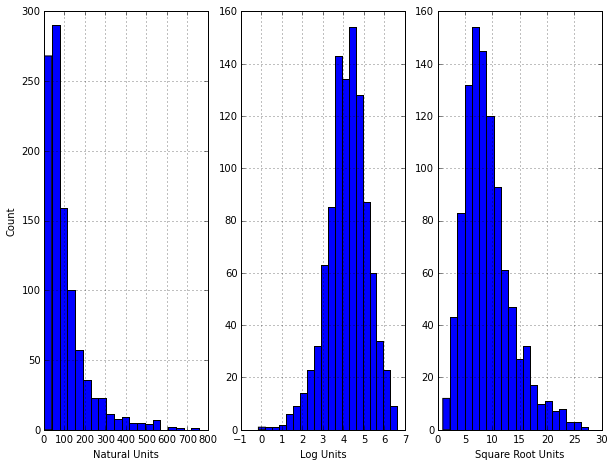

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.hist(cell_train['VarIntenCh3'].values, bins=20)
ax1.set_xlabel('Natural Units')
ax1.set_ylabel('Count')

ax2.hist(np.log(cell_train['VarIntenCh3'].values), bins=20)
ax2.set_xlabel('Log Units')

ax3.hist(np.sqrt(cell_train['VarIntenCh3'].values), bins=20)
ax3.set_xlabel('Square Root Units')

The histogram shows a strong right skewness. The log transformation seems to work well for this dataset. The ratio of the smallest to largest value and the sample skewness statistic all agree with the histogram under natural units.

In [9]:
from scipy.stats import skew

r = np.max(cell_train['VarIntenCh3'].values)/np.min(cell_train['VarIntenCh3'].values)
skewness = skew(cell_train['VarIntenCh3'].values)

print 'Ratio of the smallest to largest value is {0} \nSample skewness statistic is {1}'.format(r, skewness)

Ratio of the smallest to largest value is 870.887247203 
Sample skewness statistic is 2.39518418124


Alternatively, statistical models can be used to empirically identify an appropriate transformation. One of the most famous transformations is the Box-Cox family, i.e.
\begin{equation}
x^* = \begin{cases} {x^{\lambda}-1 \over \lambda} & \text{if} \ \lambda \neq 0 \\ log(x) & \text{if} \ \lambda = 0 \end{cases}
\end{equation}
This family covers the log ($\lambda = 0$), square ($\lambda = 2$), square root ($\lambda = 0.5$), inverse ($\lambda = -1$), and others in-between. Using the training data, $\lambda$ can be estimated using maximum likelihood estimation (MLE). This procedure would be applied independently to each predictor data that contain values **greater than 0**.

The boxcox() in *scipy.stats* finds the estimated lambda and performs the transformation at the same time.

In [10]:
from scipy.stats import boxcox

print 'Estimated lambda is {0}'.format(boxcox(cell_train['VarIntenCh3'].values)[1])

Estimated lambda is 0.121531937325


Take another predictor for example.

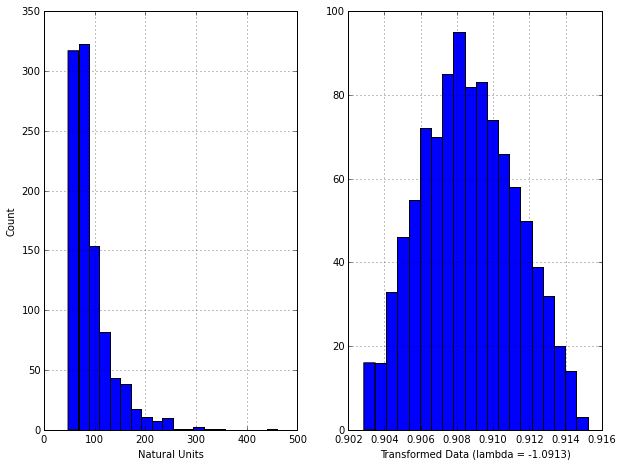

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(cell_train['PerimCh1'].values, bins=20)
ax1.set_xlabel('Natural Units')
ax1.set_ylabel('Count')

ax2.hist(boxcox(cell_train['PerimCh1'].values)[0], bins=20)
ax2.set_xlabel('Transformed Data (lambda = {:1.4f})'.format(boxcox(cell_train['PerimCh1'].values)[1]))

## 3.3 Data Transformations for Multiple Predictors

These transformations act on groups of predictors, typically the entire set under consideration. Of primary importance are methods to resolve outliers and reducce the dimension of the data.

### Transformations to Resolve Outliers

We generally define outliers as samples that are exceptionally far from the mainstream of the data. Even with a thorough understanding of the data, outliers can be hard to define. However, we can often identify an unusual value by looking at a figure. When one or more samples are suspected to be outliers, the first step is to make sure that the values are scientifically valid and that no data recording errors have occured. Great care should be taken not to hastily remove or change values, especially if the sample size is small. With small sample sizes, apparent outliers might be a result of a skewed distribution where there are not yet enough data to see the skewness. Also, the outlying data may be an indication of a special part of the population under study that is just starting to be sampled. Depending on how the data were collected, a "cluster" of valid points that reside outside the mainstream of the data might belong to a different population than the other samples, e.g. *extrapolation* and *applicability domain*. 

There are several predictive models that are resistant to outliers, e.g.
- Tree based classification models: creat splits of the training set.
- Support Vector Machines (SVM) for classification: disregard a portion if tge training set that may be far away from the decision boundary.

If a model is considered to be sensitive to outliers, one data transformation that can minimize the problem is the *spatial sign*. Mathematically, each sample is divided by its squared norm: $$x_{ij}^* = {x_{ij} \over \sqrt{\sum_{j=1}^p x_{ij}^2}}.$$ Since the denominator is intended to measure the squared distance to the center of the predictor's distribution, it is **important** to center and scale the predictor data prior to using this transformation. Note that, unlike centering and scaling, this manipulation of the predictors transform them as a group. Removing predictor variables after applying the spatial sign transformation may be problematic.

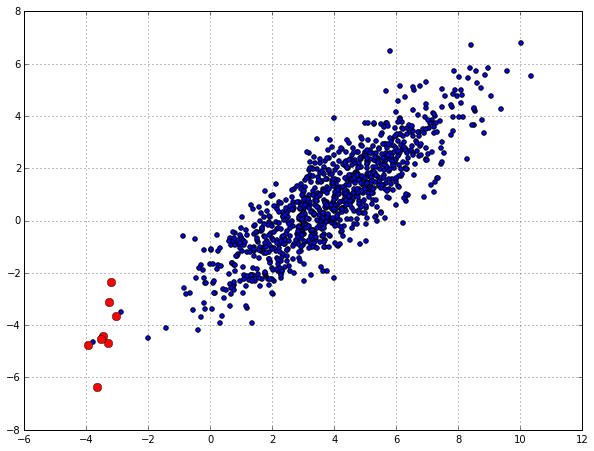

In [12]:
# toy example
beta0 = -2.3 # intercept
beta1 = 0.8 # slope
n = 1000
x1_true = np.random.normal(4, 2, n)
x2_true = np.zeros(n)

# generate a random sample
for i in xrange(n):
    x2_true[i] = beta0 + beta1*x1_true[i] + np.random.normal(size = 1)
    
# generate outliers
x1_outliers = np.random.uniform(-4, -3, 8)
x2_outliers = np.zeros(8)
for i in xrange(8):
    x2_outliers[i] = x1_outliers[i] + np.random.normal(size = 1)

plt.scatter(x1_true, x2_true)
plt.plot(x1_outliers, x2_outliers, 'ro', markersize=8)

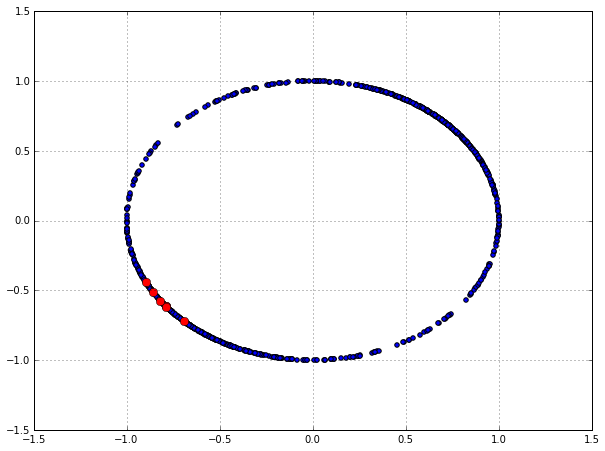

In [13]:
from sklearn.preprocessing import scale
x1 = scale(np.concatenate([x1_true, x1_outliers]))
x2 = scale(np.concatenate([x2_true, x2_outliers]))
x = np.array(zip(x1, x2))

# spatial sign
dist = x[:, 0]**2 + x[:, 1]**2
x1 = x[:, 0]/np.sqrt(dist)
x2 = x[:, 1]/np.sqrt(dist)

plt.scatter(x1[:-8], x2[:-8])
plt.plot(x1[-7:], x2[-7:], 'ro', markersize=8)

The *spatial sign* transformation brings the outliers towards the majority of the data.

### Data Reduction and Feature Extraction

These methods reduce the data by generating a smaller set of predictors that seek to capture a majority of the information in the original variables. For most data reduction techniques, the new predictors are functions of the original predictors; therefore, all the original predictors are still needed to create the surrogate variables. This class of methods is often called *signal extraction* or *feature extraction* techniques.

Principal component analysis (PCA) seeks to find linear combinations of the predictors, known as principal components (PCs), which capture the most possible variance. The first PC is defined as the linear combination of the predictors that captures the most variability of all possible linear combinations. Then, subsequent PCs are derived such that these linear combinations capture the most remaining variability while also being uncorrelated with all previous PCs. Mathematically, 
$$\text{PC}_j = (a_{j1} \times \text{Predictor 1}) + \cdots + (a_{jP} \times \text{Predictor P}).$$
P is the number of predictors. The coefficients $a_{j1}, \cdots, a_{jP}$ are called component weights and help us understand which predictors are most important to each PC.

Let us look at an example from the previous dataset.

In [14]:
cell_train_subset = cell_train[['Class', 'FiberWidthCh1', 'EntropyIntenCh1']]

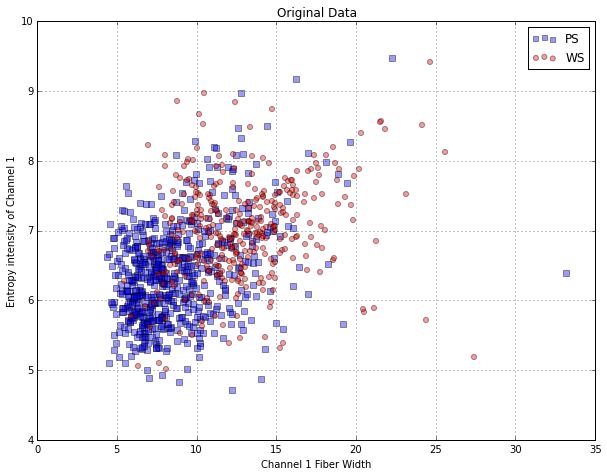

In [15]:
colors = ['b', 'r']
markers = ['s', 'o']
c = ['PS', 'WS']
for k, m in enumerate(colors):
    i = (cell_train_subset['Class'] == c[k])
    if k == 0:
        plt.scatter(cell_train_subset['FiberWidthCh1'][i], cell_train_subset['EntropyIntenCh1'][i], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='PS')
    else:
        plt.scatter(cell_train_subset['FiberWidthCh1'][i], cell_train_subset['EntropyIntenCh1'][i], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='WS')

plt.title('Original Data')
plt.xlabel('Channel 1 Fiber Width')
plt.ylabel('Entropy intensity of Channel 1')
plt.legend(loc='upper right')
plt.show()

Calculate PCs

In [16]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(cell_train_subset[['FiberWidthCh1', 'EntropyIntenCh1']])
print 'variance explained by PCs {0}'.format(pca.explained_variance_ratio_)

variance explained by PCs [ 0.96900659  0.03099341]


The first PC summarizes 97% of the original variability, while the second summarizes 3%. Hence, it is reasonable to use only the first PC for modeling since it accounts for the majority of the information in the data.

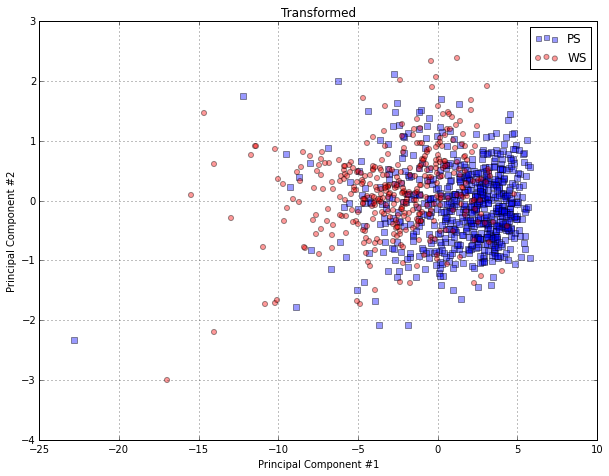

In [17]:
cell_train_subset_pca = pca.transform(cell_train_subset[['FiberWidthCh1', 'EntropyIntenCh1']])

colors = ['b', 'r']
markers = ['s', 'o']
c = ['PS', 'WS']
for k, m in enumerate(colors):
    i = np.where(cell_train_subset['Class'] == c[k])[0]
    if k == 0:
        plt.scatter(cell_train_subset_pca[i, 0], cell_train_subset_pca[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='PS')
    else:
        plt.scatter(cell_train_subset_pca[i, 0], cell_train_subset_pca[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='WS')

plt.title('Transformed')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')
plt.legend(loc='upper right')
plt.show()

The primary advantage of PCA is that it creates components that are uncorrelated. PCA preprocessing creates new predictors with desirable characteristics for models that prefer predictors to be uncorrelated.

While PCA delivers new predictors with desirable characteristics, it must be used with understanding and care. PCA seeks predictor-set variation without regard to any further understanding of the predictors (i.e. measurement scales or distributions) or to knowledge of the modeling objectives (i.e. response variable). Hence, without proper guidance, PCA can generate components that summarize characteristics of the data that are irrelevant to the underlying structure of the data and also to the ultimate modeling objectives.

PCA was applied to the entire set of segmentation data predictors.

In [18]:
cell_train.head(5)

Unnamed: 0       Cell   Case Class    AngleCh1  AngleStatusCh1  AreaCh1  \
1            2  207932307  Train    PS  133.752037               0      819   
2            3  207932463  Train    WS  106.646387               0      431   
3            4  207932470  Train    PS   69.150325               0      298   
11          12  207932484  Train    WS  109.416426               0      256   
14          15  207932459  Train    PS  104.278654               0      258   

    AreaStatusCh1  AvgIntenCh1  AvgIntenCh2     ...       VarIntenCh1  \
1               1    31.923274   205.878517     ...         18.809225   
2               0    28.038835   115.315534     ...         17.295643   
3               0    19.456140   101.294737     ...         13.818968   
11              0    18.828571   125.938776     ...         13.922937   
14              0    17.570850   124.368421     ...         12.324971   

    VarIntenCh3  VarIntenCh4  VarIntenStatusCh1  VarIntenStatusCh3  \
1     56.715352   118.388139                  0                  0   
2     37.671053    49.470524                  0                  0   
3     30.005643    24.749537                  0                  0   
11    18.643027    40.331747                  0                  0   
14    17.747143    41.928533                  0                  0   

    VarIntenStatusCh4   WidthCh1  WidthStatusCh1  XCentroid  YCentroid  
1                   0  32.161261               1        215        347  
2                   0  21.185525               0        371        252  
3                   2  13.392830               0        487        295  
11                  2  17.546861               0        211        495  
14                  2  17.660339               0        172        207  

[5 rows x 120 columns]

In [19]:
cell_train_feature = cell_train.iloc[:, 4:]
cell_train_feature.head(5)

AngleCh1  AngleStatusCh1  AreaCh1  AreaStatusCh1  AvgIntenCh1  \
1   133.752037               0      819              1    31.923274   
2   106.646387               0      431              0    28.038835   
3    69.150325               0      298              0    19.456140   
11  109.416426               0      256              0    18.828571   
14  104.278654               0      258              0    17.570850   

    AvgIntenCh2  AvgIntenCh3  AvgIntenCh4  AvgIntenStatusCh1  \
1    205.878517    69.916880   164.153453                  0   
2    115.315534    63.941748   106.696602                  0   
3    101.294737    28.217544    31.028070                  0   
11   125.938776    13.600000    46.800000                  0   
14   124.368421    22.461538    71.206478                  0   

    AvgIntenStatusCh2        ...          VarIntenCh1  VarIntenCh3  \
1                   0        ...            18.809225    56.715352   
2                   0        ...            17.295643    37.671053   
3                   0        ...            13.818968    30.005643   
11                  0        ...            13.922937    18.643027   
14                  0        ...            12.324971    17.747143   

    VarIntenCh4  VarIntenStatusCh1  VarIntenStatusCh3  VarIntenStatusCh4  \
1    118.388139                  0                  0                  0   
2     49.470524                  0                  0                  0   
3     24.749537                  0                  0                  2   
11    40.331747                  0                  0                  2   
14    41.928533                  0                  0                  2   

     WidthCh1  WidthStatusCh1  XCentroid  YCentroid  
1   32.161261               1        215        347  
2   21.185525               0        371        252  
3   13.392830               0        487        295  
11  17.546861               0        211        495  
14  17.660339               0        172        207  

[5 rows x 116 columns]

Because PCA seeks linear combinations of predictors that maximize variability, it will naturally first be drawn to summarizing predictors that have more variation. If the original predictors are on measurement scales that differ in orders of magnitude or have skewed distributions, PCA will be focusing its efforts on identifying the data structure based on measurement scales and distributional difference rather than based on the important relationships within the data for the current problem. Hence, it is best to first transform skewed predictors and then center and scale the predictors prior to performing PCA.

In [20]:
# Box-Cox transformation on positive predictors
# separate positive and non-positive predictors
pos_indx = np.where(cell_train_feature.apply(lambda x: np.all(x > 0)))[0]
cell_train_feature_pos = cell_train_feature.iloc[:, pos_indx]
print "# of positive features is {0}".format(pos_indx.shape[0])
cell_train_feature_nonpos = cell_train_feature.drop(cell_train_feature.columns[pos_indx], axis=1, inplace=False)
print "# of npn-positive features is {0}".format(cell_train_feature.shape[1] - pos_indx.shape[0])

cell_train_feature_pos_tr = cell_train_feature_pos.apply(lambda x: boxcox(x)[0])

cell_train_feature_tr = np.c_[cell_train_feature_pos_tr, cell_train_feature_nonpos]
print "The shape before/after transformation is {0} and {1}".format(cell_train_feature.shape, cell_train_feature_tr.shape)

# of positive features is 47
# of npn-positive features is 69
The shape before/after transformation is (1009, 116) and (1009, 116)


In [21]:
# scale and center predictors
from sklearn.preprocessing import scale

cell_train_feature_tr = scale(cell_train_feature_tr, with_mean=True, with_std=True)

The second caveat of PCA is that it does not consider the modeling obejective or response variable when summarizing variability -- it is an *unsupervised technique*. If the predictive relationship between the predictors and response is not connected to the predictors' variability, then the derived PCs will not provide a suitable relationship with the response. In this case, a *supervised technique*, like PLS will derive components while simultaneously considering the corresponding response.

To decide how many components to retain after PCA, a heuristic approach is to create a scree plot, which contains the ordered component number (x-axis) and the ammount of summarized variability (y-axis). Generally, the component number prior to the tapering off of variation is the maximal component that is retained. In an automated model building process, the optimal number of components can be determined by cross-validation.

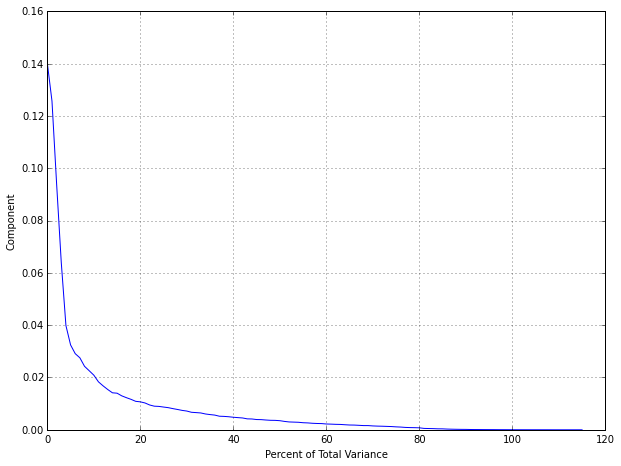

In [22]:
# conduct PCA to transformed predictors
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(cell_train_feature_tr)

# generate scree plot
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Percent of Total Variance')
plt.ylabel('Component')

In [23]:
print "The first four components account for {0} of the total variance".format(pca.explained_variance_ratio_[:4])
print "All together they account for {0} of the total variance".format(np.sum(pca.explained_variance_ratio_[:4]))

The first four components account for [ 0.14015262  0.12569721  0.09394676  0.06393814] of the total variance
All together they account for 0.42373472472 of the total variance


Visually examining the principal components is a critical step for assessing data quality and gaining intuition for the problem. To do this, the first few PCs can be plotted against each other and the plot symbols can be colored by the relevant characteristics, such as the class labels. If PCA has captured a sufficient amount of the information in the data, this type of plot can demonstrate clusters of samples or outliers that may prompt a closer examination of the individual data points. Note that the scale of the components tend to become smaller as they account for less and less variation in the data. If axes are displayed on separate scales, there is the potential to over-interpret any patterns that might be seen for components that account for small amounts of variation.

In [24]:
# look at the first 3 PCs
pca = PCA(n_components=3)
cell_train_feature_pca = pca.fit_transform(cell_train_feature_tr)

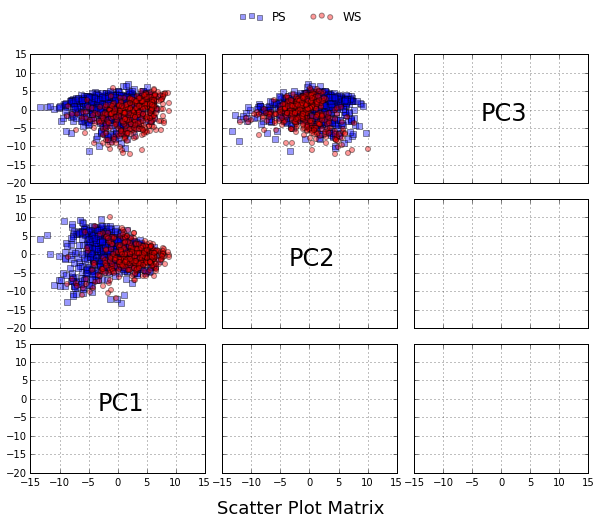

In [25]:
colors = ['b', 'r']
markers = ['s', 'o']
c = ['PS', 'WS']

fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True)

# PC1 vs PC3
for k, m in enumerate(colors):
    i = np.where(cell_train['Class'] == c[k])[0]
    if k == 0:
        line1= axarr[0,0].scatter(cell_train_feature_pca[i, 0], cell_train_feature_pca[i, 2], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='PS')
    else:
        line2= axarr[0,0].scatter(cell_train_feature_pca[i, 0], cell_train_feature_pca[i, 2], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='WS')

# PC2 vs PC3
for k, m in enumerate(colors):
    i = np.where(cell_train['Class'] == c[k])[0]
    if k == 0:
        axarr[0,1].scatter(cell_train_feature_pca[i, 1], cell_train_feature_pca[i, 2], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='PS')
    else:
        axarr[0,1].scatter(cell_train_feature_pca[i, 1], cell_train_feature_pca[i, 2], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='WS')

# PC1 vs PC2
for k, m in enumerate(colors):
    i = np.where(cell_train['Class'] == c[k])[0]
    if k == 0:
        axarr[1,0].scatter(cell_train_feature_pca[i, 0], cell_train_feature_pca[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='PS')
    else:
        axarr[1,0].scatter(cell_train_feature_pca[i, 0], cell_train_feature_pca[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='WS')

axarr[2,0].text(0.5, -1.0, 'PC1', ha='center', va='center', fontsize=24)      
axarr[1,1].text(0.5, -1.0, 'PC2', ha='center', va='center', fontsize=24)      
axarr[0,2].text(0.5, -1.0, 'PC3', ha='center', va='center', fontsize=24)
fig.legend([line1, line2], ('PS', 'WS'), loc='upper center', ncol=2, frameon=False)
fig.subplots_adjust(hspace=0.12, wspace=0.1)
fig.text(0.5, 0.06, 'Scatter Plot Matrix', ha='center', va='center', fontsize=18)

Since the percentages of variation explained are not large for the first three components, it is important not to over-interpret the resulting image. From this plot, there appears to be some separation between the classes when plotting the first and second components. However, the distribution of the well-segmented cells is roughly contained within the distribution of the poorly identified cells. One conclusion is that the cell types are not easily separated.

Another exploratory use of PCA is characterizing which predictors are associated with each component. Recall that each component is a linear combination of the predictors and the coefficient for each predictor is called the loading. Loadings close to zero indicate that the predictor variable did not contribute much to that component.

In [26]:
# loadings
pca.components_.shape

(3, 116)

## 3.4 Dealing with Missing Values

In many cases, some predictors have no values for a given sample. It is important to understand *why* the values are missing. First and foremost, it is important to know if the pattern of missing data is related to the outcome. This is called *informative missingness* since the missing data pattern is instructional on its own. Informative missingness can induce significant bias in the model.

Missing data should not be confused with *censored* data where the exact value is missing but something is known about its value. When building traditional statistical models focused on interpretation or inference, the censoring is usually taken in to account in a formal manner by making assumptions about the censoring mechanism. For predictive models, it is more common to treat these data as simple missing data or use the censored value as the observed value.

Missing values are more often related to predictive variables than the sample. Because of this, amount of missing data may be concentrated in a subset of predictors rather than occuring randomly across all the predictors. In some cases, the percentage of missing data is substantial enough to remove this predictor from subsequent modeling activities.

There are cases where the missing values might be concentrated in specific samples. For large datasets, removal of samples based on missing values is not a problem, assuming that the missingness is not informative. In smaller datasets, there is a steep price in removing samples; some of alternative approaches described below may be more appropriate.

If we do not remove the missing data, there are two general approaches. First, a few predictive models, especially tree-based techniques, can specifically account for missing data. Alternatively, missing data can be imputed. In this case, we can use information in the training set predictors to, in essence, estimate the values of other predictors.

Imputation is just another layer of modeling where we try to estimate values of the predictor variables based on other predictor variables. The most relevant scheme for accomplishing this is to use the training set to built an imputation model for each predictor in the daa set. Prior to model training or the prediction of new samples, missing values are filled in using imputation. Note that this extra layer of models adds uncertainty. If we are using resampling to select tuning parameter values or to estimate performance, the imputation should be incorporated within the resampling. This will increase the computational time for building models, but it will also provide honest estimates of model performance.

If the number of predictors affected by missing values is small, an exploratory analysis of the relationships between the preditors is a good idea. For example, visulization or methods like PCA can be used to determine if there are strong relationships between the predictors. If a variable with missing values is highly correlated with another predictor that has few missing values, a focused model can often be effective for imputation.

One popular technique for imputation is a $K$-nearest neighbor model. A new sample is imputed by finding the samples in the training set "closest" to it and averages these nearby points to fill in the value. One advantage of this approach is that the imputed data are confined to be within the range of the training set values. One disadvantage is that the entire training set is required every time a missing value needs to be imputed. Also, the number of neighbors is a tuning parameter, as is the method for determining "closeness" of two points. However, Troyanskaya et al. (2001) found the nearest neighbor approach to be fairly robust to the tuning parameters, as well as the amount of missing data.

In [27]:
# randomly sample 50 test set
import random
cell_test_subset = cell_test.iloc[np.sort(random.sample(range(cell_test.shape[0]), 50))]

# separate features
cell_test_subset_f = cell_test_subset.iloc[:, 4:].drop('VarIntenCh3', 1)
cell_test_subset_v = cell_test_subset.iloc[:, 4:]['VarIntenCh3']
cell_train_f = cell_train_feature.drop('VarIntenCh3', 1)
cell_train_v = cell_train_feature['VarIntenCh3']

In [28]:
# scale and center before imputation
from sklearn.preprocessing import StandardScaler

# standardize based on training set
sc_f = StandardScaler()
cell_train_f_sc = sc_f.fit_transform(cell_train_f)
cell_test_subset_f_sc = sc_f.transform(cell_test_subset_f)

sc_v = StandardScaler()
cell_train_v_sc = sc_v.fit_transform(cell_train_v)
cell_test_subset_v_sc = sc_v.transform(cell_test_subset_v)

In [29]:
# use 5-nearest neighbor
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors = 5)
nbrs.fit(cell_train_f_sc) # based on training set
distance, indices = nbrs.kneighbors(cell_test_subset_f_sc) # neighbors for test set

# imputation
cell_test_subset_v_pred_knn = np.empty(50)
for idx, i in enumerate(indices):
    cell_test_subset_v_pred_knn[idx] = np.mean(cell_train_v_sc[i[1:]])

Find the predictor with highest correlation.

In [30]:
from scipy.stats.stats import pearsonr

print "corr('VarIntenCh3', 'DiffIntenDensityCh3') is {0}".format(pearsonr(cell_train_v, cell_train_f['DiffIntenDensityCh3'])[0])

corr('VarIntenCh3', 'DiffIntenDensityCh3') is 0.894871504785


In [31]:
# use linear model
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(cell_train_f_sc[:, cell_train_f.columns.get_loc('DiffIntenDensityCh3')][:, np.newaxis],
       cell_train_v_sc[:, np.newaxis]) # find the predictor with highest correlation
cell_test_subset_v_pred_lm = \
lm.predict(cell_test_subset_f_sc[:, cell_train_f.columns.get_loc('DiffIntenDensityCh3')][:, np.newaxis])

Correlation between the real and imputed values

In [32]:
print "kNN: {0}".format(pearsonr(cell_test_subset_v_sc, cell_test_subset_v_pred_knn)[0])
print "Linear Model: {0}".format(pearsonr(cell_test_subset_v_sc[:, np.newaxis], cell_test_subset_v_pred_lm)[0][0])

kNN: 0.869781133553
Linear Model: 0.858789107105


Note that the better performance of linear model is because of the high correlation (0.895) between these two predictors. kNN is generally more robust since it takes all predictors into consideration.

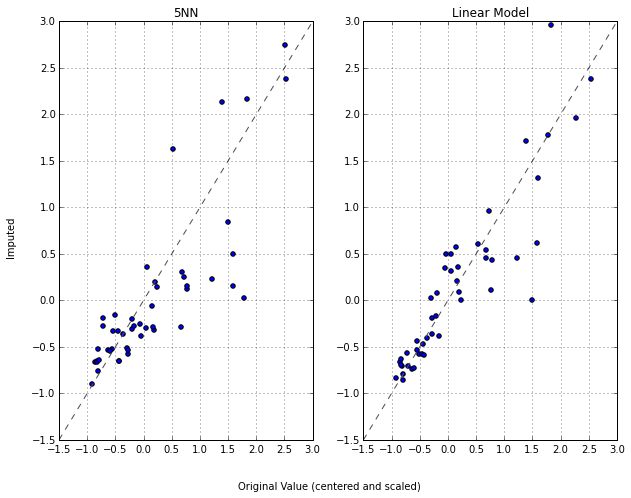

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(cell_test_subset_v_sc, cell_test_subset_v_pred_knn)
ax1.set(xlim=(-1.5, 3), ylim=(-1.5, 3))
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
ax1.set_title('5NN')

ax2.scatter(cell_test_subset_v_sc, cell_test_subset_v_pred_lm)
ax2.set(xlim=(-1.5, 3), ylim=(-1.5, 3))
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
ax2.set_title('Linear Model')

fig.text(0.5, 0.04, 'Original Value (centered and scaled)', ha='center', va='center')
fig.text(0.06, 0.5, 'Imputed', ha='center', va='center', rotation='vertical')

## 3.5 Removing Predictors

There are potential advantages to removing predictors prior to modeling. First, fewer predictors means decreased computational time and complexity. Second, if two predictors are highly correlated, this implies that they are measuring the same underlying information. Removing one should not compromise the performance of the model and might lead to a more parsimonious and interpretable model. Third, some models can be crippled by predictors with degenerate distributions, e.g. near-zero variance predictors. In these cases, there can be a significant improvement in model performance and/or stability without the problematic variables.

A rule of thumb for detecting near-zero variance predictors:
- The fraction of unique values over the sample size is low (say 10%)
- The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (say around 20)

If both of these criteria are true and the model in question is susceptible to this type of predictor, it may be advantageous to remove the variable from the model.

### Between-Predictor Correlations

*Collinearity* is the technical term for the situation where a pair of predictor variables have a substantial correlation with each other. It is also possible to have relationships between multiple predictors at once (called *multicollinearity*).

A direct visualization of the correlation matrix from the training set.

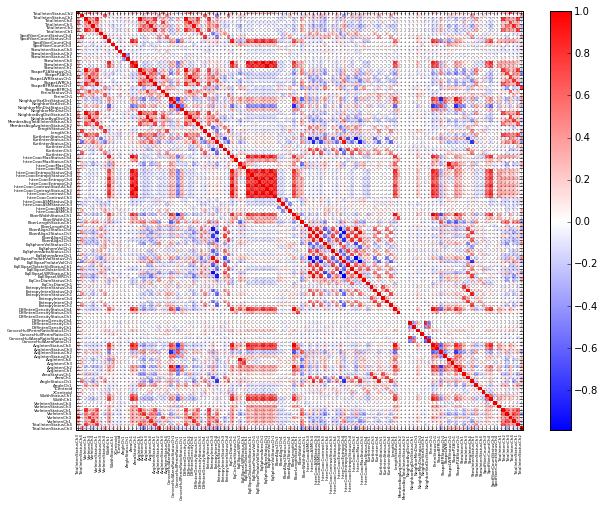

In [34]:
# calculate the correlation matrix
corr_dataframe = cell_train_feature.corr()

# compute hierarchical cluster on both rows and columns for correlation matrix and plot heatmap 
def corr_heatmap(corr_dataframe):
    import scipy.cluster.hierarchy as sch
    
    corr_matrix = np.array(corr_dataframe)
    col_names = corr_dataframe.columns
    
    Y = sch.linkage(corr_matrix, 'single', 'correlation')
    Z = sch.dendrogram(Y, color_threshold=0, no_plot=True)['leaves']
    corr_matrix = corr_matrix[Z, :]
    corr_matrix = corr_matrix[:, Z]
    col_names = col_names[Z]
    im = plt.imshow(corr_matrix, interpolation='nearest', aspect='auto', cmap='bwr')
    plt.colorbar()
    plt.xticks(range(corr_matrix.shape[0]), col_names, rotation='vertical', fontsize=4)
    plt.yticks(range(corr_matrix.shape[0]), col_names[::-1], fontsize=4)
    
# plot
corr_heatmap(corr_dataframe)

Note that the predictor variables have been grouped using a clustering technique so that collinear groups of predictors are adjacent to one another.

When the data set consists of too many predictors to examine visually, techniques such as PCA can be used to characterize the magnitude of the problem. For example, if the first principal component accounts for a large percentage of the variance, this implies that there is at least one group of predictors that represent the same information. The PCA loadings can be used to understand which predictors are associated with each component to tease out this relationship.

In general, there are good reasons to avoid data with highly correlated predictors. First, redundant predictors frequently add more complexity to the model than information they provide to the model. In situations where obtaining the predictor data is costly, fewer variables is obviously better. Using highly correlated predictors in techniques like linear regression can result in highly unstable models, numerical values, and degraded predictive performances.

Classical regression analysis has several tools to diagnose multicollinearity for linear regression. A statistic called the variance inflation factor (VIF) can be used to identify predictors that are impacted. A common rule of thumb is that if VIF > 5, then multicollinearity is high. Note that this method is developed for linear models, it requires more samples than predictor variables and it does not determine which should be removed to resolve the problem

A more heuristic approach is to remove the minimum number of predictors to ensure that all pairwise correlation are below a certain threshold. The algorithm is as follows:
- Calculate the correlation matrix of the predictors.
- Determine the two predictors associated with the largest absolute pairwise correlation (A and B).
- Determine the average absolute correlation between A and the other variables. Do the same for predictor B.
- If A has a larger average correlation, remove it; otherwise, remove predictor B.
- Repeat Steps 2-4 until no absolute correlations are above the threshold.

Suppose we wanted to use a model that is particularly sensitive to between predictor correlations, we might apply a threshold of 0.75.

As previously mentioned, feature extraction methods (e.g., principal components) are another technique for mitigating the effect of strong correlations between predictors. However, these techniques make the connection between the predictors and the outcome more complex. Additionally, since signal extraction methods are usually unsupervised, there is no guarantee that the resulting surrogate preditors have any relationship with the outcome.

## 3.6 Adding Predictors

When a predictor is categorical, it is common to decompose the predictor into a set of more specific variables.

Look at the following example for the credit scoring data.

In [35]:
!ls -l ../datasets/GermanCredit/

total 480
-rw-r--r--  1 leigong  staff  244776 Nov 24 15:58 GermanCredit.csv


In [36]:
credit_data = pd.read_csv("../datasets/GermanCredit/GermanCredit.csv")
credit_data.head(5)

Unnamed: 0  Duration  Amount  InstallmentRatePercentage  ResidenceDuration  \
0           1         6    1169                          4                  4   
1           2        48    5951                          2                  2   
2           3        12    2096                          2                  3   
3           4        42    7882                          2                  4   
4           5        24    4870                          3                  4   

   Age  NumberExistingCredits  NumberPeopleMaintenance  Telephone  \
0   67                      2                        1          0   
1   22                      1                        1          1   
2   49                      1                        2          1   
3   45                      1                        2          1   
4   53                      2                        2          1   

   ForeignWorker      ...       OtherInstallmentPlans.Bank  \
0              1      ...                                0   
1              1      ...                                0   
2              1      ...                                0   
3              1      ...                                0   
4              1      ...                                0   

   OtherInstallmentPlans.Stores  OtherInstallmentPlans.None  Housing.Rent  \
0                             0                           1             0   
1                             0                           1             0   
2                             0                           1             0   
3                             0                           1             0   
4                             0                           1             0   

   Housing.Own  Housing.ForFree  Job.UnemployedUnskilled  \
0            1                0                        0   
1            1                0                        0   
2            1                0                        0   
3            0                1                        0   
4            0                1                        0   

   Job.UnskilledResident  Job.SkilledEmployee  \
0                      0                    1   
1                      0                    1   
2                      1                    0   
3                      0                    1   
4                      0                    1   

   Job.Management.SelfEmp.HighlyQualified  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  

[5 rows x 63 columns]

In [37]:
credit_data.shape

(1000, 63)

The predictor based on how much money was in the applicant's saving account is categorical coded into dummy variables.

In [38]:
credit_data_saving = credit_data[['SavingsAccountBonds.lt.100', 'SavingsAccountBonds.100.to.500', 
                                  'SavingsAccountBonds.500.to.1000', 'SavingsAccountBonds.gt.1000', 
                                  'SavingsAccountBonds.Unknown']]
credit_data_saving.head(10)

SavingsAccountBonds.lt.100  SavingsAccountBonds.100.to.500  \
0                           0                               0   
1                           1                               0   
2                           1                               0   
3                           1                               0   
4                           1                               0   
5                           0                               0   
6                           0                               0   
7                           1                               0   
8                           0                               0   
9                           1                               0   

   SavingsAccountBonds.500.to.1000  SavingsAccountBonds.gt.1000  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
5                                0                            0   
6                                1                            0   
7                                0                            0   
8                                0                            1   
9                                0                            0   

   SavingsAccountBonds.Unknown  
0                            1  
1                            0  
2                            0  
3                            0  
4                            0  
5                            1  
6                            0  
7                            0  
8                            0  
9                            0

In [39]:
credit_data_saving.apply(np.sum)

SavingsAccountBonds.lt.100         603
SavingsAccountBonds.100.to.500     103
SavingsAccountBonds.500.to.1000     63
SavingsAccountBonds.gt.1000         48
SavingsAccountBonds.Unknown        183
dtype: float64

| Value    |  n   | <100 | 100-500 | 500-1000 | >1000 | Unknown |                                           
|:---------|:----:|:----:|:-------:|:--------:|:-----:|:-------:|
| < 100    | 603  |   1  |   0     |    0     |   0   |    0    |
| 100-500  | 100  |   0  |   1     |    0     |   0   |    0    |
| 500-1000 |  63  |   0  |   0     |    1     |   0   |    0    |
| >1000    |  48  |   0  |   0     |    0     |   1   |    0    |
| Unknown  | 183  |   0  |   0     |    0     |   0   |    1    |


Usually, each category gets its own dummy variable that is a zero/one indicator for that group. Only four dummy variables are needed here, the fifth can be inferred. However, the decision to include all of the dummy variables can depend on the choice of the model. Models that include an intercept term, such as simple linear model, would have numerical issues if each dummy variable was included in the model. The reason is that, for each sample, these variables all add up to one and this would provide the same information as the intercept. If the model is insensitive to this type of issue, using the complete set of dummy variables would help improve interpretation of the model.

Many of the advanced models automatically generate highly complex, nonlinear relationships between the predictors and the outcome. More simplistic models do not unless the user manually specifices which predictors should be nonlinear and in what way. Another technique to augment the prediction data for classification model is through the "*class centroids*", which are the centers of the predictor data for each class. For each predictor, the distance to each class centroid can be calculated and these distances can be added to the model.

## 3.7 Binning Predictors (to avoid)

There are many issues with the manual binning of continuous data. First, there can be a significant loss of performance in the model. Second, there is a loss of precision in the predictions when the predictors are categorized. Unfortunately, the predictive models that are most powerful are usually the least interpretable. The bottom line is that the perceived improvement in interpretability gained by manual categorization is usually offset by a significant loss in performance.

Note that the argument here is related to the *manual* categorization of predictors prior to model building. There are several models, such as classification/regression trees and multivariate adaptive regression splines, that estimate cut points in the process of model building. The difference between these methodologies and manual binning is that the models ues all the predictors to derive bins based on a single objective (such as maximizing accuracy). They evaluate many variable simultaneously and are usually based on statistically sound methodologies.